In [21]:
import pandas as pd
import numpy as np
from ast import literal_eval
import re
import dataframe_image as dfi
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib notebook

from scipy.stats import mannwhitneyu

In [22]:
df = pd.read_csv('../data/bayut/cleaned/ready_flats_clean.csv', converters={'amenities': literal_eval})
df = df[(df['surface'] <= 4000)]
df.set_index('listing_id', inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28767 entries, 5825610 to 4178490
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   URL              28767 non-null  object 
 1   building         15759 non-null  object 
 2   district         28767 non-null  object 
 3   neighborhood     28414 non-null  object 
 4   price            28767 non-null  int64  
 5   beds             27141 non-null  float64
 6   baths            28767 non-null  int64  
 7   surface          28767 non-null  float64
 8   lat              28767 non-null  float64
 9   long             28767 non-null  float64
 10  highlights       28767 non-null  object 
 11  furnishing       16980 non-null  object 
 12  amenities        28767 non-null  object 
 13  completion_year  28767 non-null  int64  
 14  floor            782 non-null    float64
 15  price_sqf        28767 non-null  float64
 16  views            28767 non-null  int64  
 17  disc

In [24]:
df = df[df['beds'].notna()]
               
df2 = (df.groupby(['district','beds','baths'])['price_sqf']
         .agg([('median_sqf','median')])
         .reset_index())
df2

,district,beds,baths,median_sqf
0,Al Barari,0.0,1,753.768844
1,Al Barari,1.0,1,1443.974104
2,Al Barari,1.0,2,1294.033528
3,Al Barari,1.0,3,1288.056206
4,Al Barari,2.0,2,1797.479763
...,...,...,...,...
707,World Trade Centre,2.0,4,1213.702853
708,World Trade Centre,3.0,3,1511.503711
709,World Trade Centre,3.0,4,1360.544218
710,World Trade Centre,4.0,4,1346.097642


In [25]:
df = df.merge(df2, on=['district', 'beds', 'baths'], how='left')  
df.head()

,URL,building,district,neighborhood,price,beds,baths,surface,lat,long,...,distressed,investment,tenanted,vacant,metro,furnished,condition,upgraded,luxury,median_sqf
0,https://www.bayut.com/property/details-5825610...,Wilton Terraces 2,Mohammed Bin Rashid City,Sobha Hartland,1483773,1.0,1,815.0,25.177226,55.308851,...,0,0,0,1,0,0,0,NaN,0,1717.459350
1,https://www.bayut.com/property/details-5933491...,NaN,Jumeirah Village Circle (JVC),Eaton Place,1250000,2.0,2,1141.0,25.060612,55.200228,...,0,1,0,0,0,0,0,NaN,0,873.786408
2,https://www.bayut.com/property/details-5933545...,Binghatti Mirage,Jumeirah Village Circle (JVC),JVC District 10,650000,1.0,2,618.0,25.064736,55.207565,...,0,1,0,1,0,0,1,NaN,1,813.285914
3,https://www.bayut.com/property/details-5933677...,NaN,Jumeirah Village Circle (JVC),Rigel Apartments,740000,1.0,2,933.0,25.063390,55.202050,...,0,0,0,0,0,1,0,NaN,0,813.285914
4,https://www.bayut.com/property/details-5929393...,Golden Mile 6,Palm Jumeirah,Golden Mile,2500000,2.0,2,1794.0,25.109089,55.144157,...,0,0,0,0,0,0,0,upgraded,0,1611.111111


In [26]:
# https://www.bayut.com/tru-value
# 1 Bed, 1 Bath, 1,078 sqft apartment for sale in Dubai Marina (1550 AED)
# <768.9 | 768.9-1100 | 1100-2000 | 2000-2300 | >2300
# ...-50 | -50...-30  | -30...30  | 30...50   | >50...


# [...-50%] — great value (very undervalued)
# (-50...-30%] — good value (undervalued)
# (-30...+30%] — fair value
# (+30...+50%] — overvalued
# (+50...] — highly overvalued

diff_percent = ((df['price_sqf'] / df['median_sqf']) * 100) - 100
df['diff_percent'] = diff_percent

def val_conditions(row):
    if (row['diff_percent'] <= -50):
        return 'great value'
    elif (row['diff_percent'] > -50) & (row['diff_percent'] <= -30):
        return 'good value'
    elif (row['diff_percent'] > -30) & (row['diff_percent'] <= 30):
        return 'fair value'
    elif (row['diff_percent'] > 30) & (row['diff_percent'] <= 50):
        return 'overvalued'
    elif (row['diff_percent'] > 50):
        return 'highly overvalued' 

df['valuation'] = df.apply(lambda row: val_conditions(row), axis=1)

In [27]:
df

,URL,building,district,neighborhood,price,beds,baths,surface,lat,long,...,tenanted,vacant,metro,furnished,condition,upgraded,luxury,median_sqf,diff_percent,valuation
0,https://www.bayut.com/property/details-5825610...,Wilton Terraces 2,Mohammed Bin Rashid City,Sobha Hartland,1483773,1.0,1,815.0,25.177226,55.308851,...,0,1,0,0,0,NaN,0,1717.459350,6.004277,fair value
1,https://www.bayut.com/property/details-5933491...,NaN,Jumeirah Village Circle (JVC),Eaton Place,1250000,2.0,2,1141.0,25.060612,55.200228,...,0,0,0,0,0,NaN,0,873.786408,25.377349,fair value
2,https://www.bayut.com/property/details-5933545...,Binghatti Mirage,Jumeirah Village Circle (JVC),JVC District 10,650000,1.0,2,618.0,25.064736,55.207565,...,0,1,0,0,1,NaN,1,813.285914,29.324745,fair value
3,https://www.bayut.com/property/details-5933677...,NaN,Jumeirah Village Circle (JVC),Rigel Apartments,740000,1.0,2,933.0,25.063390,55.202050,...,0,0,0,1,0,NaN,0,813.285914,-2.477051,fair value
4,https://www.bayut.com/property/details-5929393...,Golden Mile 6,Palm Jumeirah,Golden Mile,2500000,2.0,2,1794.0,25.109089,55.144157,...,0,0,0,0,0,upgraded,0,1611.111111,-13.504786,fair value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27136,https://www.bayut.com/property/details-4659412...,NaN,Dubai Residence Complex,Skycourts Towers,369000,1.0,2,734.0,25.091303,55.385476,...,0,1,0,0,0,NaN,0,644.329897,-21.977112,fair value
27137,https://www.bayut.com/property/details-4513630...,Jumeirah Living,World Trade Centre,World Trade Centre Residence,1850960,2.0,2,1851.0,25.226713,55.289187,...,0,0,0,0,0,NaN,0,1212.291557,-17.513375,fair value
27138,https://www.bayut.com/property/details-4408791...,Icon Tower 1,Jumeirah Lake Towers (JLT),Icon Tower,900000,2.0,3,1098.0,25.064754,55.138866,...,0,0,0,0,0,NaN,0,959.462233,-14.569630,fair value
27139,https://www.bayut.com/property/details-4364937...,New Dubai Gate 1,Jumeirah Lake Towers (JLT),JLT Cluster Q,680000,2.0,2,798.0,25.076278,55.146149,...,0,0,0,0,0,NaN,0,989.427413,-13.876418,fair value


In [28]:
df['valuation'].value_counts()

fair value           20919
good value            2093
overvalued            2036
highly overvalued     1823
great value            270
Name: valuation, dtype: int64

In [29]:
undervalued = df[(df['valuation'] == 'good value') | (df['valuation'] == 'great value')]
undervalued

,URL,building,district,neighborhood,price,beds,baths,surface,lat,long,...,tenanted,vacant,metro,furnished,condition,upgraded,luxury,median_sqf,diff_percent,valuation
22,https://www.bayut.com/property/details-5909479...,Sobha Daffodil Wing A,Jumeirah Village Circle (JVC),Sobha Daffodil,450000,1.0,2,933.0,25.047142,55.206906,...,0,0,0,0,0,NaN,0,813.285914,-40.695504,good value
38,https://www.bayut.com/property/details-5886675...,NaN,Downtown Dubai,Mada Residences by ARTAR,3299989,3.0,4,2196.0,25.193583,55.285234,...,0,0,0,1,0,NaN,0,2794.026136,-46.216422,good value
45,https://www.bayut.com/property/details-5885791...,Golden Mile 8,Palm Jumeirah,Golden Mile,2600000,2.0,3,2500.0,25.110662,55.141861,...,0,0,0,0,0,NaN,0,1611.111111,-35.448276,good value
82,https://www.bayut.com/property/details-5843261...,Golden Mile 6,Palm Jumeirah,Golden Mile,1500000,1.0,1,1288.0,25.109089,55.144157,...,0,1,0,0,0,NaN,0,2462.286415,-52.702648,great value
114,https://www.bayut.com/property/details-5683231...,NaN,Dubai Marina,Elite Residence,3499999,3.0,3,3175.0,25.089626,55.148014,...,0,0,0,0,0,upgraded,0,1610.824742,-31.565374,good value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27094,https://www.bayut.com/property/details-5567868...,Shams 4,Jumeirah Beach Residence (JBR),Shams,1450000,2.0,2,1171.0,25.072898,55.130092,...,0,0,0,0,0,NaN,0,1872.074883,-33.856391,good value
27099,https://www.bayut.com/property/details-5529126...,NaN,International City,NaN,330000,1.0,0,976.0,25.166455,55.407332,...,0,0,0,0,0,NaN,0,582.533640,-41.957901,good value
27103,https://www.bayut.com/property/details-5470344...,Grenland Residence,Mohammed Bin Rashid City,District 11,1316181,2.0,2,1502.0,25.127874,55.355857,...,0,0,0,0,0,NaN,0,1621.375306,-45.954178,good value
27118,https://www.bayut.com/property/details-5206972...,NaN,Jumeirah,City Walk,3800000,3.0,4,2815.0,25.208299,55.258058,...,0,0,0,0,0,NaN,0,2100.000000,-35.718515,good value


In [30]:
undervalued.to_csv('../data/bayut/cleaned/ready_flats_undervalued.csv')

In [31]:
under_df = undervalued[['district', 'beds', 'baths', 'price']]
under_df['price'] = under_df['price'] / 1000

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_1568\421412564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  under_df['price'] = under_df['price'] / 1000


In [32]:
undervalued['district'].value_counts().nlargest(10)

Dubai Marina                      772
Downtown Dubai                    476
Jumeirah Village Circle (JVC)     294
Business Bay                      161
Palm Jumeirah                     137
Jumeirah Beach Residence (JBR)     89
Mohammed Bin Rashid City           68
Arjan                              61
Jumeirah Lake Towers (JLT)         33
Town Square                        21
Name: district, dtype: int64

In [33]:
ten_districts = ['Dubai Marina', 'Downtown Dubai', 'Jumeirah Village Circle (JVC)',\
                'Business Bay', 'Palm Jumeirah', 'Jumeirah Beach Residence (JBR)',\
                'Mohammed Bin Rashid City', 'Arjan', 'Jumeirah Lake Towers (JLT)',\
                'Town Square']

under_df = undervalued.copy()

under_df = under_df[(under_df['beds'] <= 3) & (under_df['district'].isin(ten_districts))]
under_df['price'] = under_df['price'] / 1000
under_df['price'] = under_df['price'].astype(int)
under_df['beds'] = under_df['beds'].astype(int)

under_table = pd.pivot_table(under_df, values='price', index=['district'],
                    columns=['beds'], aggfunc=np.median)

under_table

beds,0,1,2,3
district,,,,
Arjan,315.0,472.5,679.5,NaN
Business Bay,540.0,877.5,1250.0,2000.0
Downtown Dubai,632.5,1200.0,1800.0,3585.0
Dubai Marina,497.0,750.0,1250.0,2000.0
Jumeirah Beach Residence (JBR),NaN,1439.5,1650.0,3100.0
Jumeirah Lake Towers (JLT),430.0,620.0,910.0,1299.5
Jumeirah Village Circle (JVC),327.5,484.5,720.0,1427.5
Mohammed Bin Rashid City,NaN,832.0,1200.0,1690.0
Palm Jumeirah,1051.5,1650.0,2000.0,3490.0


<IPython.core.display.Javascript object>


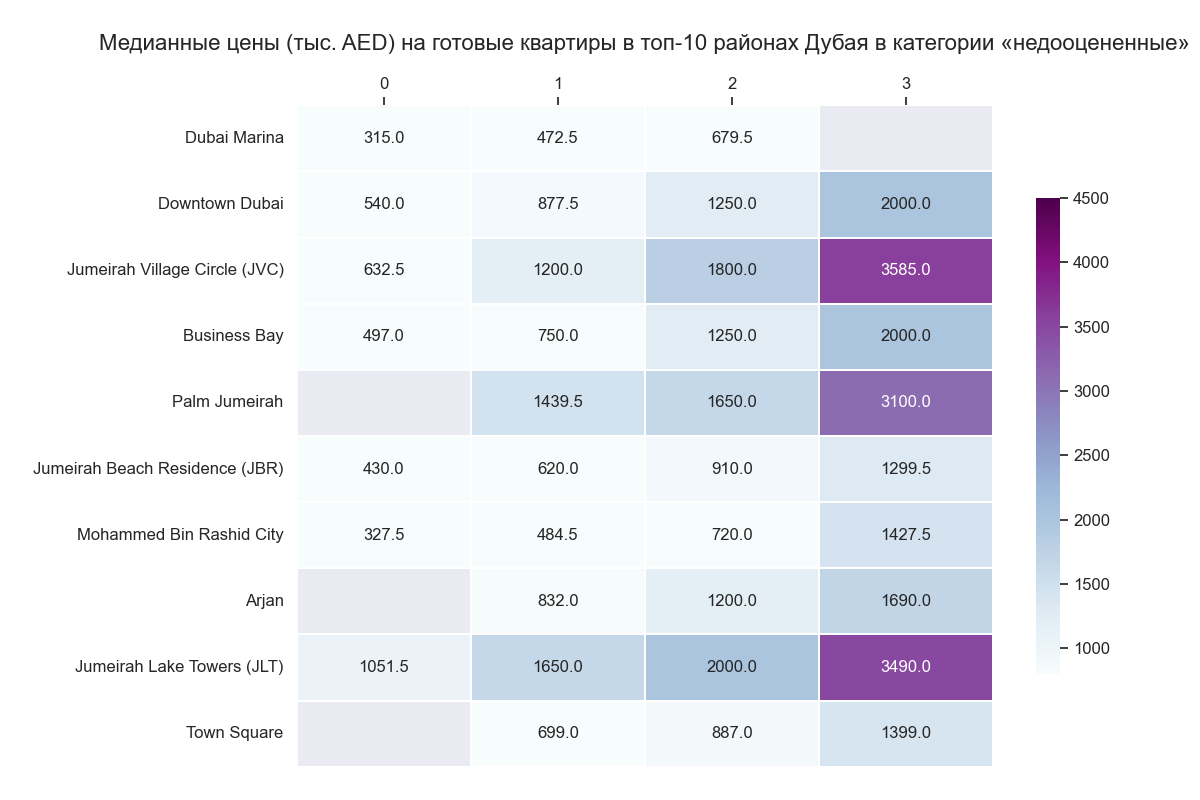

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(under_table, 
            cmap='BuPu', 
            vmin=800, 
            vmax=4500, 
#             square=True,
            linewidth=0.3, 
            cbar_kws={'shrink': .72}, 
          annot=True, 
          fmt='.1f'
           )

yticks_labels = ten_districts
plt.yticks(np.arange(10) + .5, labels=yticks_labels)
ax.xaxis.tick_top()

plt.xlabel('')
plt.ylabel('')
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set(fontsize=12)

title = 'Медианные цены (тыс. AED) на готовые квартиры в топ-10 районах Дубая в категории «недооцененные»'
plt.title(title, fontsize=16, pad=20)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(pad=2)

In [35]:
plt.savefig('../images/readyf_heatmap.png')

In [38]:
selected_undervalued = undervalued[((undervalued['discounted']==1) | \
                                   (undervalued['cheap']==1) | \
                                   (undervalued['distressed']==1) | \
                                   (undervalued['condition'] == '')) & \
                                   (undervalued['completion_year'] < 2017)]

selected_undervalued

,URL,building,district,neighborhood,price,beds,baths,surface,lat,long,...,tenanted,vacant,metro,furnished,condition,upgraded,luxury,median_sqf,diff_percent,valuation
176,https://www.bayut.com/property/details-5628051...,Lake Point Tower,Jumeirah Lake Towers (JLT),JLT Cluster N,900000,2.0,4,1590.0,25.063355,55.137683,...,0,1,0,0,0,NaN,0,982.435038,-42.384207,good value
178,https://www.bayut.com/property/details-5638988...,NaN,Business Bay,Ontario Tower,900000,2.0,2,982.0,25.186073,55.262314,...,0,0,0,0,0,NaN,0,1411.161581,-35.053720,good value
371,https://www.bayut.com/property/details-5881862...,NaN,Dubai Marina,Azure,1450000,2.0,2,1732.0,25.073000,55.137402,...,0,0,0,0,0,NaN,0,1528.255528,-45.219734,good value
654,https://www.bayut.com/property/details-5690702...,Golden Mile 9,Palm Jumeirah,Golden Mile,1400000,1.0,2,1307.0,25.111828,55.140392,...,1,0,0,0,0,NaN,0,2158.894646,-50.384086,great value
660,https://www.bayut.com/property/details-5740303...,NaN,Dubai Marina,The Torch,1200000,2.0,2,1258.0,25.087900,55.147400,...,1,0,0,0,0,NaN,0,1528.255528,-37.582750,good value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25201,https://www.bayut.com/property/details-5706932...,NaN,Downtown Dubai,Damac Maison The Distinction,2910000,3.0,4,1849.0,25.187985,55.279714,...,0,0,0,1,0,NaN,0,2794.026136,-43.671834,good value
25325,https://www.bayut.com/property/details-5762592...,NaN,Dubai Marina,Marina Pinnacle,900000,2.0,2,1219.0,25.088699,55.148201,...,0,0,0,0,0,NaN,0,1528.255528,-51.689356,great value
25332,https://www.bayut.com/property/details-4986591...,Creek Gate,The Lagoons,Dubai Creek Harbour,2209888,2.0,3,1982.0,25.200451,55.343027,...,0,0,0,0,0,NaN,0,1683.140431,-33.756044,good value
26214,https://www.bayut.com/property/details-5340030...,The Residences,Mohammed Bin Rashid City,District One,1200000,1.0,2,1400.0,25.170647,55.278257,...,0,0,0,0,0,NaN,0,1639.892445,-47.731764,good value


In [39]:
selected_undervalued.describe()

,price,beds,baths,surface,lat,long,completion_year,floor,price_sqf,views,...,distressed,investment,tenanted,vacant,metro,furnished,condition,luxury,median_sqf,diff_percent
count,1.380000e+02,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,3.000000,138.000000,138.000000,...,138.000000,138.000000,138.000000,138.000000,138.0,138.000000,138.000000,138.000000,138.000000,138.000000
mean,1.139020e+06,1.550725,2.304348,1275.884058,25.105289,55.220266,640.268116,23.333333,845.546130,0.268116,...,0.152174,0.094203,0.130435,0.101449,0.0,0.050725,0.065217,0.028986,1421.775694,-40.047325
std,7.931489e+05,0.802118,0.971181,527.692831,0.056583,0.070996,939.245096,34.355980,346.260060,0.444592,...,0.360498,0.293175,0.338008,0.303023,0.0,0.220234,0.247809,0.168377,570.523769,7.411711
min,2.700000e+05,0.000000,1.000000,480.000000,24.986540,55.127410,0.000000,3.000000,345.887017,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,586.596988,-58.879653
25%,5.037500e+05,1.000000,2.000000,866.250000,25.063276,55.148283,0.000000,3.500000,559.068170,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,921.506257,-43.894176
50%,9.375000e+05,1.000000,2.000000,1178.500000,25.082981,55.212774,0.000000,4.000000,805.399392,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1458.436982,-38.159165
75%,1.557500e+06,2.000000,3.000000,1616.500000,25.175513,55.271048,2007.000000,33.500000,1020.334287,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1639.892445,-34.226250
max,4.950000e+06,3.000000,5.000000,2780.000000,25.224609,55.425344,2012.000000,63.000000,1910.112360,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,2876.984127,-30.137507


In [40]:
selected_undervalued.to_csv('../data/bayut/cleaned/ready_flats_undervalued_wproblems.csv')

In [41]:
parameters = ['price', 'beds', 'baths', 'surface']
median_problematic = selected_undervalued.groupby(['district'])[parameters].agg(lambda x: list(x.median()))
median_problematic

,price,beds,baths,surface
district,,,,
Arjan,475000.0,1.0,2.0,839.5
Business Bay,1137500.0,2.0,2.0,1273.5
DAMAC Hills,925000.0,1.0,2.0,2346.0
DAMAC Hills 2 (Akoya by DAMAC),1200000.0,3.0,4.0,1905.0
DIFC,2100000.0,2.0,3.0,1875.0
Downtown Dubai,1700000.0,2.0,3.0,1390.0
Dubai Harbour,2300000.0,1.5,2.0,1329.0
Dubai Hills Estate,2820443.0,3.0,4.0,2780.0
Dubai Marina,1080000.0,2.0,2.0,1238.5


In [42]:
quantities = selected_undervalued['price'].groupby(selected_undervalued['district']).count()
quantities

district
Arjan                              6
Business Bay                       6
DAMAC Hills                        1
DAMAC Hills 2 (Akoya by DAMAC)     1
DIFC                               1
Downtown Dubai                    25
Dubai Harbour                      2
Dubai Hills Estate                 1
Dubai Marina                      34
Dubai Sports City                  4
Dubailand                          2
International City                 2
Jumeirah Beach Residence (JBR)     2
Jumeirah Lake Towers (JLT)         3
Jumeirah Village Circle (JVC)     33
Meydan City                        1
Mirdif                             1
Mohammed Bin Rashid City           6
Motor City                         1
Palm Jumeirah                      4
The Lagoons                        2
Name: price, dtype: int64

In [43]:
median_problematic['quantity'] = quantities
median_problematic

,price,beds,baths,surface,quantity
district,,,,,
Arjan,475000.0,1.0,2.0,839.5,6
Business Bay,1137500.0,2.0,2.0,1273.5,6
DAMAC Hills,925000.0,1.0,2.0,2346.0,1
DAMAC Hills 2 (Akoya by DAMAC),1200000.0,3.0,4.0,1905.0,1
DIFC,2100000.0,2.0,3.0,1875.0,1
Downtown Dubai,1700000.0,2.0,3.0,1390.0,25
Dubai Harbour,2300000.0,1.5,2.0,1329.0,2
Dubai Hills Estate,2820443.0,3.0,4.0,2780.0,1
Dubai Marina,1080000.0,2.0,2.0,1238.5,34


In [45]:
median_problematic[['price', 'beds', 'baths', 'surface']] = median_problematic[['price', 'beds', 'baths', 'surface']].astype(int)
median_problematic = median_problematic.sort_values(by='quantity', ascending=False)
median_problematic

,price,beds,baths,surface,quantity
district,,,,,
Dubai Marina,1080000,2,2,1238,34
Jumeirah Village Circle (JVC),465000,1,2,870,33
Downtown Dubai,1700000,2,3,1390,25
Arjan,475000,1,2,839,6
Mohammed Bin Rashid City,1224859,2,3,1547,6
Business Bay,1137500,2,2,1273,6
Palm Jumeirah,1799995,1,2,1597,4
Dubai Sports City,372500,0,1,877,4
Jumeirah Lake Towers (JLT),715000,1,2,1195,3


In [46]:
dfi.export(median_problematic, '../images/readyf_undervalued_with_problems.png')

In [47]:
overvalued = df[(df['valuation'] == 'overvalued') | (df['valuation'] == 'highly overvalued')]
overvalued.describe()

,price,beds,baths,surface,lat,long,completion_year,floor,price_sqf,views,...,distressed,investment,tenanted,vacant,metro,furnished,condition,luxury,median_sqf,diff_percent
count,3.859000e+03,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,80.000000,3859.000000,3859.000000,...,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000
mean,3.585284e+06,1.749935,2.515678,1308.000272,25.117923,55.204610,263.173879,21.012500,2539.727471,0.598342,...,0.000777,0.087069,0.055714,0.105727,0.002332,0.164032,0.120238,0.058824,1541.046374,64.131252
std,3.089866e+06,0.870233,1.026578,611.684685,0.063740,0.074127,678.323336,49.718064,1206.579057,0.490297,...,0.027875,0.281973,0.229398,0.307528,0.048243,0.370353,0.325282,0.235325,565.777760,47.643327
min,2.300000e+05,0.000000,0.000000,96.000000,24.862205,54.949708,0.000000,1.000000,557.971014,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,423.260423,30.004677
25%,1.650000e+06,1.000000,2.000000,838.000000,25.072222,55.139762,0.000000,4.750000,1837.592191,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1305.237542,37.525662
50%,2.800000e+06,2.000000,2.000000,1167.000000,25.098852,55.181465,0.000000,14.000000,2339.531494,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1524.779462,48.268368
75%,4.549995e+06,2.000000,3.000000,1700.000000,25.186663,55.273898,0.000000,22.750000,3160.270880,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1872.074883,69.835781
max,3.500000e+07,4.000000,6.000000,3890.000000,25.269741,55.423065,2025.000000,443.000000,13415.101571,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4835.988504,856.521739


In [48]:
undervalued.describe()

,price,beds,baths,surface,lat,long,completion_year,floor,price_sqf,views,...,distressed,investment,tenanted,vacant,metro,furnished,condition,luxury,median_sqf,diff_percent
count,2.363000e+03,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,63.000000,2363.000000,2363.000000,...,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000
mean,1.360572e+06,1.642827,2.378756,1384.359289,25.112541,55.208058,734.317393,11.746032,953.939965,0.374524,...,0.009310,0.143039,0.119340,0.142192,0.025391,0.132036,0.089716,0.044012,1600.899808,-39.840234
std,9.269902e+05,0.855462,0.977740,611.931546,0.058173,0.070587,967.431811,15.903913,360.730749,0.484102,...,0.096059,0.350186,0.324257,0.349321,0.157344,0.338601,0.285836,0.205165,619.323488,7.673554
min,2.300000e+05,0.000000,0.000000,384.000000,24.862205,55.050665,0.000000,1.000000,193.810455,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,481.077614,-79.854178
25%,7.000000e+05,1.000000,2.000000,947.000000,25.068288,55.142411,0.000000,2.000000,716.235304,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1305.237542,-44.404717
50%,1.170000e+06,2.000000,2.000000,1292.000000,25.088699,55.204947,0.000000,5.000000,920.809392,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1524.779462,-37.929067
75%,1.700000e+06,2.000000,3.000000,1653.500000,25.186943,55.272023,2007.000000,13.500000,1117.964534,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1938.837297,-33.727451
max,8.400000e+06,4.000000,6.000000,3993.000000,25.257749,55.440595,2023.000000,71.000000,2840.909091,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5000.000000,-30.008530


In [49]:
df_forplot = df.copy()
df_forplot['price'] = df_forplot['price'] / 1000

In [50]:
def draw_scatterplot():
    g = sns.relplot(x='price', 
            y='surface', 
            hue='valuation', 
            data=df_forplot,
            alpha=.7, 
            palette='muted', 
            height=8, 
            aspect=8/8)

    title = 'Вторичные квартиры в Дубае, сгруппированные по оценке'
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Цена, тыс. AED')
    plt.ylabel('Площадь, кв. футов')
    plt.subplots_adjust(top=0.85)

<IPython.core.display.Javascript object>


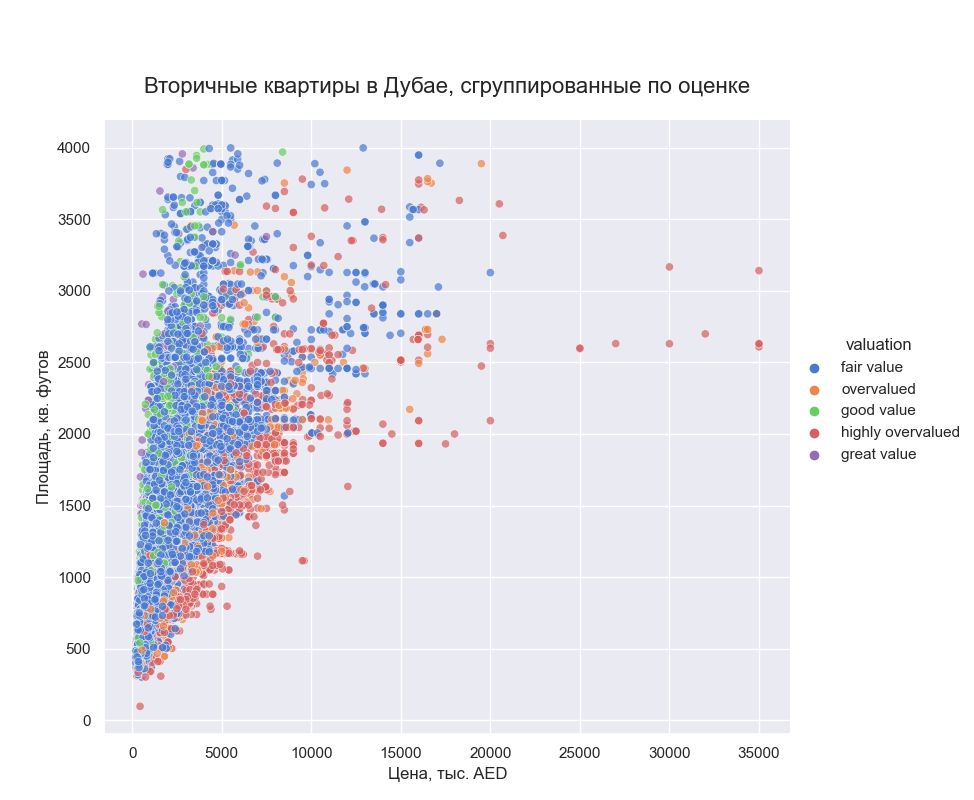

In [52]:
draw_scatterplot()

In [53]:
plt.savefig('../images/readyf_valuations_relplot.png')

<IPython.core.display.Javascript object>


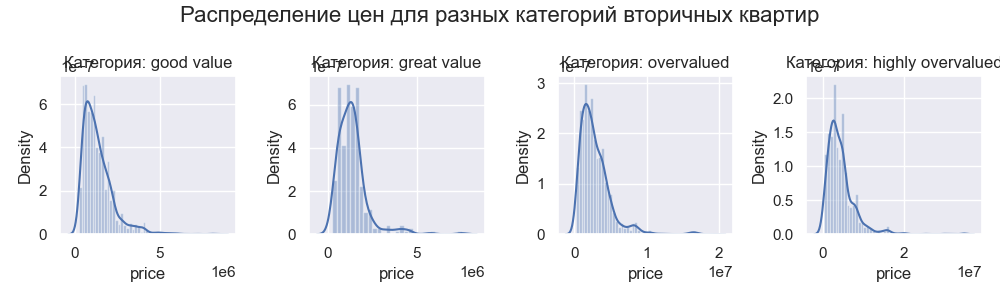

C:\Users\Julia\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Julia\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Julia\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

In [54]:
def plot_hists():
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,3))
    fig.suptitle('Распределение цен для разных категорий вторичных квартир', fontsize=16)

    # Hist 1 --------------------------------------------------
    ax1.set_title('Категория: good value')
    sns.distplot(df[(df['valuation']=='good value')]['price'], hist=True, kde=True, ax=ax1)

    # Hist 2 --------------------------------------------------
    ax2.set_title('Категория: great value')
    sns.distplot(df[(df['valuation']=='great value')]['price'], hist=True, kde=True, ax=ax2)
    
    # Hist 3 --------------------------------------------------
    ax3.set_title('Категория: overvalued')
    sns.distplot(df[(df['valuation']=='overvalued')]['price'], hist=True, kde=True, ax=ax3)
    
    # Hist 4 --------------------------------------------------
    ax4.set_title('Категория: highly overvalued')
    sns.distplot(df[(df['valuation']=='highly overvalued')]['price'], hist=True, kde=True, ax=ax4)
    
    plt.tight_layout()
    
plot_hists()

In [55]:
great_value = df[(df['valuation']=='great value') | (df['valuation']=='good value')]['price']
highly_overvalued = df[(df['valuation']=='highly overvalued')]['price']

U1, p = mannwhitneyu(great_value, highly_overvalued, method='auto', nan_policy='propagate')
format(p, '.3f')

'0.000'

<IPython.core.display.Javascript object>


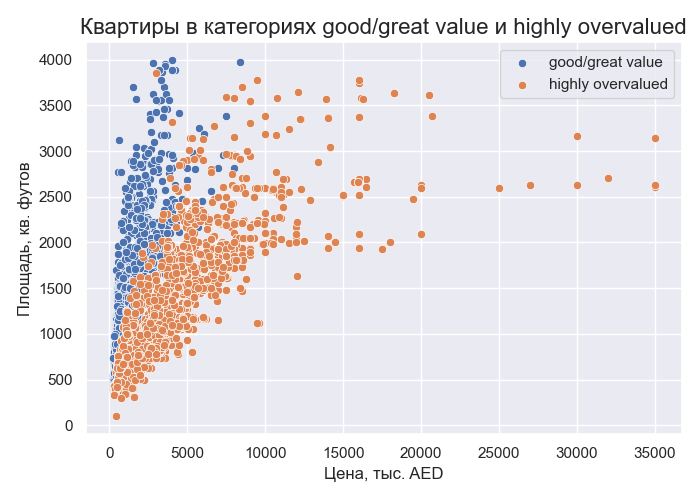

C:\Users\Julia\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Julia\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [56]:
g_value = df_forplot[(df_forplot['valuation']=='great value') | (df_forplot['valuation']=='good value')]
h_overvalued = df_forplot[(df_forplot['valuation']=='highly overvalued')]

def plot_scatter():
    fig1 = plt.subplots(1, 1, figsize=(7,5))
    
    sns.scatterplot(g_value['price'], g_value['surface'], label='good/great value')
    sns.scatterplot(h_overvalued['price'], h_overvalued['surface'], label='highly overvalued')
    plt.xlabel('Цена, тыс. AED')
    plt.ylabel('Площадь, кв. футов')
    plt.title('Квартиры в категориях good/great value и highly overvalued', fontsize=16)
    plt.legend(loc="upper right")
    
    plt.tight_layout()
    
plot_scatter()

In [57]:
plt.savefig('../images/readyf_extr_val_scatterplot.png')

In [103]:
U1, p = mannwhitneyu(g_value['price'], h_overvalued['price'], method='auto', nan_policy='propagate')
format(p, '.3f')

'0.000'

In [58]:
g_value.describe()

,price,beds,baths,surface,lat,long,completion_year,floor,price_sqf,views,...,distressed,investment,tenanted,vacant,metro,furnished,condition,luxury,median_sqf,diff_percent
count,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,63.000000,2363.000000,2363.000000,...,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000
mean,1360.571529,1.642827,2.378756,1384.359289,25.112541,55.208058,734.317393,11.746032,953.939965,0.374524,...,0.009310,0.143039,0.119340,0.142192,0.025391,0.132036,0.089716,0.044012,1600.899808,-39.840234
std,926.990233,0.855462,0.977740,611.931546,0.058173,0.070587,967.431811,15.903913,360.730749,0.484102,...,0.096059,0.350186,0.324257,0.349321,0.157344,0.338601,0.285836,0.205165,619.323488,7.673554
min,230.000000,0.000000,0.000000,384.000000,24.862205,55.050665,0.000000,1.000000,193.810455,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,481.077614,-79.854178
25%,700.000000,1.000000,2.000000,947.000000,25.068288,55.142411,0.000000,2.000000,716.235304,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1305.237542,-44.404717
50%,1170.000000,2.000000,2.000000,1292.000000,25.088699,55.204947,0.000000,5.000000,920.809392,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1524.779462,-37.929067
75%,1700.000000,2.000000,3.000000,1653.500000,25.186943,55.272023,2007.000000,13.500000,1117.964534,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1938.837297,-33.727451
max,8400.000000,4.000000,6.000000,3993.000000,25.257749,55.440595,2023.000000,71.000000,2840.909091,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5000.000000,-30.008530


In [59]:
h_overvalued.describe()

,price,beds,baths,surface,lat,long,completion_year,floor,price_sqf,views,...,distressed,investment,tenanted,vacant,metro,furnished,condition,luxury,median_sqf,diff_percent
count,1823.000000,1823.000000,1823.000000,1823.000000,1823.000000,1823.000000,1823.000000,31.000000,1823.000000,1823.000000,...,1823.000000,1823.000000,1823.000000,1823.000000,1823.000000,1823.000000,1823.000000,1823.000000,1823.000000,1823.000000
mean,4391.848988,1.792649,2.583653,1354.283511,25.115465,55.194746,229.492046,16.129032,3013.982074,0.640154,...,0.000549,0.069665,0.053209,0.113001,0.001097,0.158530,0.112452,0.055952,1559.686893,92.510109
std,3687.318713,0.870804,1.042192,654.142730,0.064545,0.073476,639.651072,17.042578,1359.634874,0.480087,...,0.023421,0.254652,0.224512,0.316680,0.033113,0.365337,0.316008,0.229892,510.795195,56.940241
min,319.999000,0.000000,0.000000,96.000000,24.862205,54.949708,0.000000,1.000000,707.671958,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,423.260423,50.003882
25%,2199.495000,1.000000,2.000000,840.500000,25.072222,55.136245,0.000000,3.000000,2316.433566,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1337.625228,59.482485
50%,3528.000000,2.000000,2.000000,1181.000000,25.086517,55.148481,0.000000,9.000000,2800.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1528.255528,71.915513
75%,5300.000000,2.000000,3.000000,1758.000000,25.188306,55.271766,0.000000,21.500000,3769.573148,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1872.074883,105.521513
max,35000.000000,4.000000,6.000000,3850.000000,25.240309,55.423065,2025.000000,71.000000,13415.101571,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4835.988504,856.521739


In [75]:
g_value['upgraded'].value_counts()

upgraded          39
fully upgraded     5
renovated          2
Name: upgraded, dtype: int64

In [76]:
h_overvalued['upgraded'].value_counts()

upgraded          14
fully upgraded     9
renovated          2
Name: upgraded, dtype: int64

In [77]:
df.to_csv('../data/bayut/cleaned/ready_flats_valuation.csv')